# Reinforcement Learning

Gdy nie mamy potrzeby/możliwości zbudowania uniwersalnego modelu, możemy nauczyć się dokładnej instrukcji działania dopasowanej do danego problemu. Podejmując na początku losowe decyzje, nagradzamy te, które prowadzą do lepszego rozwiązania. Jednym z dostępnych algorytmów w Reinforcement Learning jest Q-learning. Bazuje on na równaniu Bellmana:
 $$Q(s,a) = (1-\alpha )Q(s,a) + \alpha(reward + \gamma(max(Q(s_{new},:))))$$

 $$Q(s,a) = (1-\alpha )\cdot Q(s,a) + \alpha \left[r + \gamma \cdot \max(s_{new},:) \right]$$

 $\gamma$ - discount rate

Q w tym przypadku to tablica 100x4 (100 pól, 4 akcje - góra, lewo, dół, prawo), reward to wypłata po zagraniu wybranego ruchu, a parametry alfa i gamma to odpowiednio learning rate i discount rate (jak ważna jest sama perspektywa dobrej wypłaty) mieszczące się w przedziale (0,1).

# Zadanie do wykonanie:
1. Znajdź optymalne wyjście z labiryntu. <br>
2. Dodaj funkcjonalość sprawiającą że w każdej  nowej iteracji algorytm wykorzystuje to co się już nauczył (dodatkowo).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


#### Kodowanie

2 - meta

1 - aktualna pozycja

0 - dostepne pole

-1 - sciana/niedostepna komorka

-2 - start

In [ ]:
maze = np.array([[-2., 0, 0, 0,-1,-1, 0, 0, 0,-1],
                 [ 0,-1, 0, 0,-1, 0, 0,-1, 0,-1],
                 [ 0, 0,-1,-1,-1, 0,-1,-1, 0, 0],
                 [-1, 0, 0, 0,-1, 0, 0, 0,-1, 0],
                 [ 0,-1,-1, 0,-1, 0,-1, 0,-1, 0],
                 [ 0, 0,-1, 0, 0,-1, 0, 0, 0, 0],
                 [ 0,-1,-1,-1, 0, 0,-1, 0,-1, 0],
                 [ 0, 0, 0, 0, 0,-1, 0, 0,-1, 0],
                 [ 0,-1,-1,-1,-1, 0,-1, 0,-1, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0,-1, 2]])
print(maze.shape)

(10, 10)


In [ ]:
def draw(maze, actual_pos = None):
  if actual_pos is not None:
      maze_copy = maze.copy()
      maze[actual_pos[0], actual_pos[1]] = 1.
  ax.set_xticks(np.arange(0.5, len(maze), 1))
  ax.set_yticks(np.arange(0.5, len(maze[0]), 1))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  img = plt.imshow(maze, cmap='seismic')
  plt.text(0-0.3, 0, 'start', color='white')
  plt.text(9-0.25, 9, 'finish', color='white')
  plt.grid('on')
  if actual_pos is not None:
      maze = maze_copy

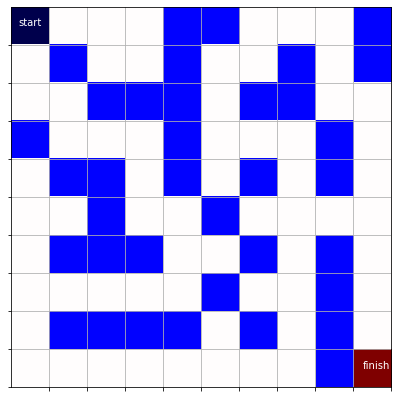

In [ ]:
plt.figure(figsize=(7, 7))
ax = plt.gca()
draw(maze)

In [ ]:
import random
from typing import List
import time

starting_point = [0, 0]


MOVES = {
    'LEFT':  [0, -1], 
    'UP':    [-1, 0], 
    'RIGHT': [0, 1], 
    'DOWN':  [+1, 0]
}

MOVES_inv = {
    0: 'LEFT',
    1: 'UP', 
    2: 'RIGHT',
    3: 'DOWN',
}

class Maze:

    def __init__(self, maze, starting_point, epochs):
        self.maze = maze
        self.epochs = epochs
        self.learning_rate = 0.5
        self.discount_rate = 0.5
        self.Q = np.zeros(
            shape = (
                maze.shape[0]*maze.shape[1], 
                len(MOVES)
            )
        )
        self.starting_position = list(starting_point)
        self.actual_position = list(starting_point)
        self.iteration = 0
        self.END_GAME = False
        self.previous_wrong_moves = []
        self.fig = plt.figure(figsize=(7,7))

    def next_position(self, move: str) -> List[int]:
        '''converts `move` to list containing new position's coordinates
        '''
        [coord_x, coord_y] = [
                              self.actual_position[0] + MOVES[move][0],
                              self.actual_position[1] + MOVES[move][1]
                             ]
        return [coord_x, coord_y]

    def update_position(self, next_position: List[int]):
        '''updates `self.actual_position` accordingly to `next_position`
        '''
        self.actual_position[0] = next_position[0]
        self.actual_position[1] = next_position[1]

    def is_right(self, move: str) -> bool:
        '''checks if the turn is right. 
        If there's something blocking the way it returns `False`
        '''
        #coordinates of next position
        [coord_x, coord_y] = self.next_position(move)

        #maze boundaries
        if coord_x < 0 or coord_x >= self.maze.shape[0]:
            return False
            
        if coord_y < 0 or coord_y >= self.maze.shape[1]:
            return False
        
        #wall
        if int(self.maze[coord_x, coord_y]) == -1:
            return False
        
        return True

    def make_move(self) -> str:
        '''makes a random choice of a move. 
        Updates Q matrix.
        '''
        move = random.choice(
            list(
                set(MOVES) - set(self.previous_wrong_moves)
            )
        )
        self.iteration += 1
        next_position = self.next_position(move)

        i = self.maze.shape[1]*self.actual_position[0] + self.actual_position[1]
        i_new = self.maze.shape[1]*next_position[0] + next_position[1]
        j = list(MOVES.keys()).index(move)

        if self.is_right(move):
            reward = -0.05
        else:
            reward = -1
            i_new = i
        if i_new == 99:
            reward = 1
        
        self.Q[i, j] = (1.0 - self.learning_rate)*self.Q[i, j] + (reward + self.discount_rate * max(self.Q[i_new, :]))

        return move

    def train(self) -> int:
        '''main method simulating game.
        Returns number of iterations.
        '''
        for epoch in range(self.epochs):
            self.END_GAME = False
            self.actual_position = self.starting_position.copy()
            while not self.END_GAME:
                move = self.make_move()
                while not self.is_right(move):
                    self.previous_wrong_moves.append(move)
                    move = self.make_move()
                
                self.previous_wrong_moves = []
                next_position = self.next_position(move)
                if int(self.maze[next_position[0], next_position[1]]) == 2:
                    self.END_GAME = True

                self.update_position(next_position)
                if self.END_GAME:
                    break
        return self.Q

    def walk(self, plotting: bool = False):
        self.END_GAME = False
        self.actual_position = self.starting_position.copy()
        self.iteration = 0
        moves_list = []
        i = self.maze.shape[1]*self.actual_position[0] + self.actual_position[1]
        while not self.END_GAME:
            # print(self.actual_position)
            move = np.argmax(Q[i])
            move = MOVES_inv[move] 
            print(move)
            moves_list.append(move)
            next_position = self.next_position(move)
            self.update_position(next_position)
            self.iteration += 1
            i = self.maze.shape[1]*self.actual_position[0] + self.actual_position[1]

            if int(self.maze[self.actual_position[0], self.actual_position[1]]) == 2:
                self.END_GAME = True

            if self.END_GAME:
                return moves_list, self.iteration

            if plotting:
                self.fig.clf()
                draw(self.maze.copy(), actual_pos = self.actual_position)
                plt.show()
            
            if self.iteration > 500:
                raise Exception("Too many iterations. Something's wrong :(")

In [ ]:
maze_runner = Maze(
    maze = maze,
    starting_point = (0, 0),
    epochs = 100
)
Q = maze_runner.train()
print(Q)

[[-3.30000000e+00 -3.30000000e+00 -1.50000000e+00 -1.30000000e+00]
 [-1.40000000e+00 -3.40000000e+00 -1.60000000e+00 -3.40000000e+00]
 [-1.50000000e+00 -3.50000000e+00 -1.70000000e+00 -1.70000000e+00]
 [-1.60000000e+00 -3.60000000e+00 -3.60000000e+00 -1.80000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.10000000e+00 -1.10000000e+00  9.00000000e-01  7.00000000e-01]
 [ 8.00000000e-01 -1.00000000e+00  1.00000000e+00 -1.00000000e+00]
 [ 9.00000000e-01 -9.00000000e-01 -9.00000000e-01  1.10000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.20000000e+00 -1.40000000e+00 -3.20000000e+00 -1.20000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.60000000e+00 -1.60000000e+00 -1.80000000e+00 -3.60000000e+00]
 [-1.70000000e+00 -1.70000000e+00 -3.70000000e+00 -3.70000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e

<Figure size 504x504 with 0 Axes>

Wyrysowanie drogi od startu do mety (bez startu i mety, bo one już są zaznaczone)

DOWN


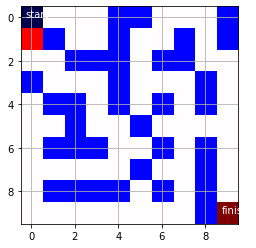

DOWN


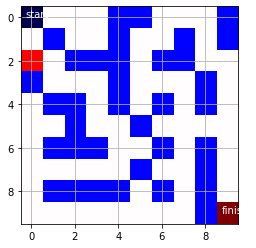

RIGHT


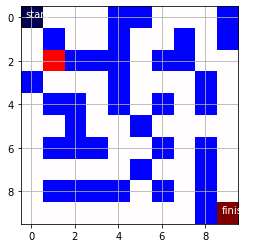

DOWN


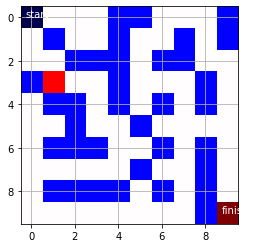

RIGHT


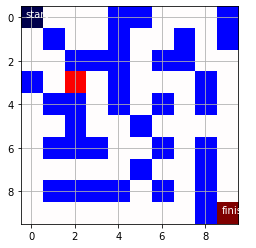

RIGHT


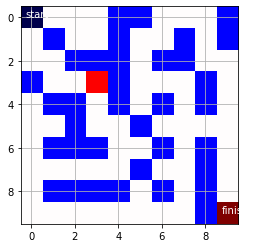

DOWN


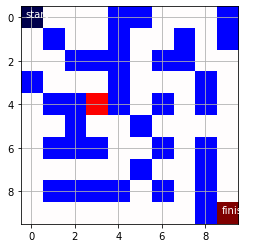

DOWN


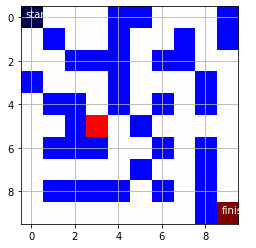

RIGHT


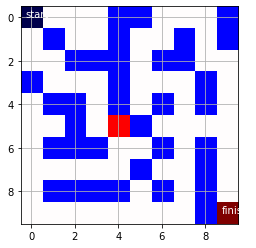

DOWN


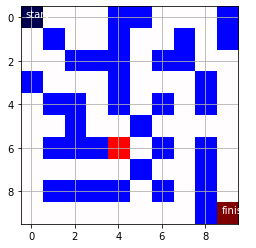

DOWN


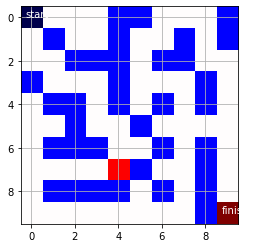

LEFT


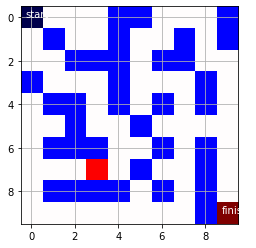

LEFT


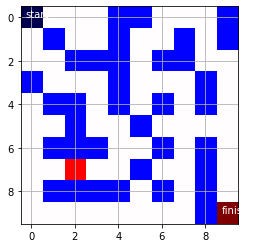

LEFT


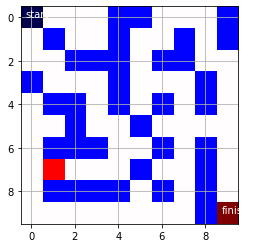

LEFT


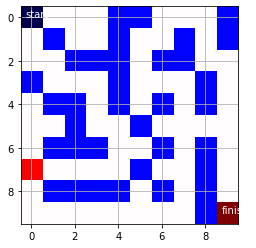

DOWN


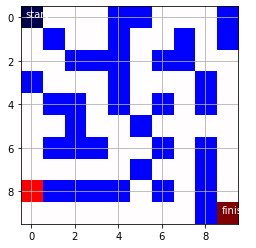

DOWN


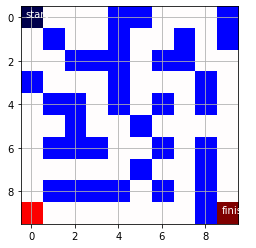

RIGHT


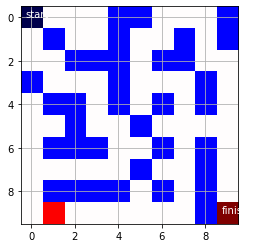

RIGHT


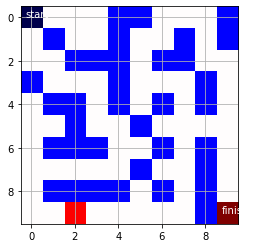

RIGHT


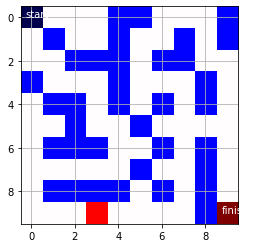

RIGHT


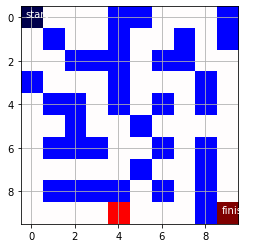

RIGHT


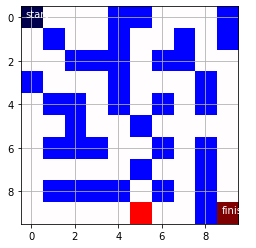

RIGHT


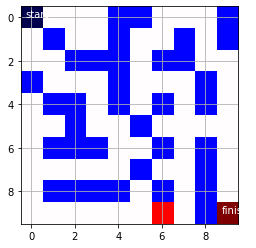

RIGHT


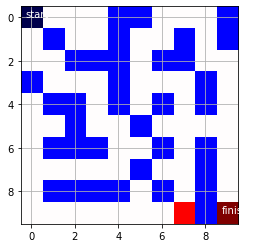

UP


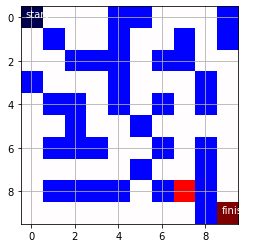

UP


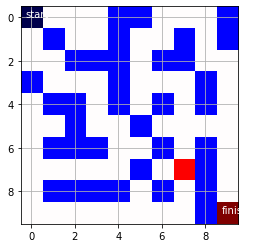

UP


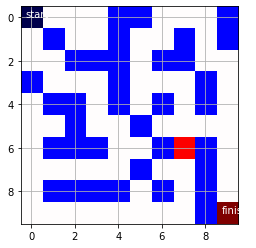

UP


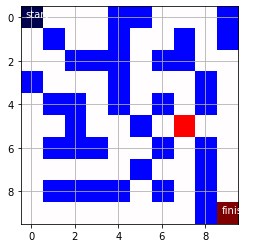

RIGHT


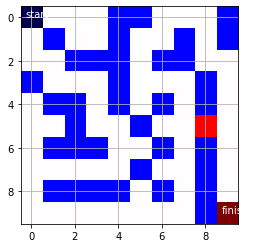

RIGHT


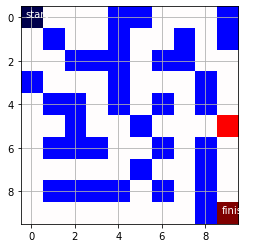

DOWN


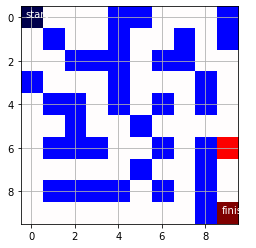

DOWN


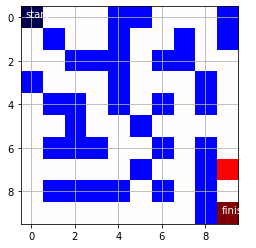

DOWN


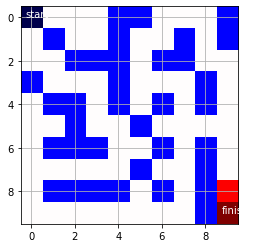

DOWN
number of iterations: 34


In [ ]:
moves, it = maze_runner.walk(plotting=True)
print(f"number of iterations: {it}")
# print(f"Moves:\n{moves}")

`make_move`:

1. wylosuj ruch
1. jezeli ruch jest niedozwolony, to wylosuj ruch, ktory jest dozwolony
1. przesuwamy sie tam
1. aktualizujemy $Q$ dla tego ruchu
1. powtarzamy to, az osiagniemy mete